<a href="https://colab.research.google.com/github/ejrtks1020/Kaggle-competition/blob/main/Face_Mask_Detection_Inference_(RetinaNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

In [ ]:
!pip install --upgrade albumentations

In [3]:
import os

os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [4]:
!kaggle datasets download -d andrewmvd/face-mask-detection

face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!mkdir mask_dataset

mkdir: cannot create directory ‘mask_dataset’: File exists


In [ ]:
!unzip face-mask-detection.zip -d mask_dataset

In [1]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
from bs4 import BeautifulSoup
from PIL import Image
import numpy as np
import time
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
import random

In [2]:
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)
  return [xmin, ymin, xmax, ymax]

def generate_label(obj):
  if obj.find('name').text == 'with_mask':
    return 1
  elif obj.find('name').text == 'mask_weared_incorrect':
    return 2
  return 0

def generate_target(file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'html.parser')
    objects = soup.find_all('object')

    num_objs = len(objects)

    boxes = []
    labels = []
    #각 오브젝트에서 바운딩박스와 label 추출
    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))
    
    boxes = torch.as_tensor(boxes, dtype = torch.float32) # 추후 딥러닝 모델학습을 위한 tensor간 연산을 위해 tensor로 변환
    labels = torch.as_tensor(labels, dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    return target

In [3]:
def plot_image_from_output_cv(img, annotation):
  img = img.permute(1, 2, 0)
  img2 = np.array(img.numpy() * 255, dtype = np.uint8)
  img_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

  for i in range(len(annotation['boxes'])):
    bbox = annotation['boxes'][i]
    left = int(bbox[0])
    top = int(bbox[1])
    right = int(bbox[2])
    bottom = int(bbox[3])
    
    if annotation['labels'][i] == 0:
      color = (0, 0, 255) # red color
      text = 'without_mask'
    elif annotation['labels'][i] == 1:
      color = (0, 255, 0) # green color
      text = 'with_mask'
    else:
      color = (255, 0, 0) # blue color
      text = 'mask_incorrect'
    cv2.rectangle(img_bgr, (left, top), (right, bottom), color = color, thickness = 1)

    cv2.putText(img_bgr, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4,color = color, thickness = 1)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (10, 10))
  plt.imshow(img_rgb)

In [3]:
img_list = sorted(glob.glob('mask_dataset/images/*'))
annot_list = sorted(glob.glob('mask_dataset/annotations/*'))

In [10]:
%cd mask_dataset
!mkdir test_annotations; mkdir test_images

/content/mask_dataset
mkdir: cannot create directory ‘test_annotations’: File exists
mkdir: cannot create directory ‘test_images’: File exists


In [11]:
# 전체 데이터셋 개수가 적으므로 8:2 비율로 테스트 데이터를 생성한다
from sklearn.model_selection import train_test_split
train_idx , test_idx = train_test_split(range(853), test_size = 0.2 ,random_state = 1234)

In [12]:
len(train_idx), len(test_idx)

(682, 171)

In [13]:
test_idx[:10]

[620, 534, 348, 148, 230, 277, 322, 503, 501, 89]

In [14]:
import shutil
for img in np.array(sorted(os.listdir('images')))[test_idx]:
  shutil.move('images/' + img, 'test_images/' + img)

for img in np.array(sorted(os.listdir('annotations')))[test_idx]:
  shutil.move('annotations/' + img, 'test_annotations/' + img)

In [15]:
#각 디렉토리 파일 개수 확인
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_images')))
print(len(os.listdir('test_annotations')))

682
682
171
171


In [16]:
!pwd
%cd ..

/content/mask_dataset
/content


In [1]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
from bs4 import BeautifulSoup
from PIL import Image
import numpy as np
import time
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
import random

In [2]:
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)
  return [xmin, ymin, xmax, ymax]

def generate_label(obj):
  if obj.find('name').text == 'with_mask':
    return 1
  elif obj.find('name').text == 'mask_weared_incorrect':
    return 2
  return 0

def generate_target(file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'html.parser')
    objects = soup.find_all('object')

    num_objs = len(objects)

    boxes = []
    labels = []
    #각 오브젝트에서 바운딩박스와 label 추출
    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))
    
    boxes = torch.as_tensor(boxes, dtype = torch.float32) # 추후 딥러닝 모델학습을 위한 tensor간 연산을 위해 tensor로 변환
    labels = torch.as_tensor(labels, dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    return target

In [10]:
def plot_image_from_output_cv(img, annotation):
  img = img.permute(1, 2, 0)
  img2 = np.array(img.numpy() * 255, dtype = np.uint8)
  img_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

  for i in range(len(annotation['boxes'])):
    bbox = annotation['boxes'][i]
    left = int(bbox[0])
    top = int(bbox[1])
    right = int(bbox[2])
    bottom = int(bbox[3])
    
    if annotation['labels'][i] == 0:
      color = (0, 0, 255) # red color
      text = 'without_mask'
    elif annotation['labels'][i] == 1:
      color = (0, 255, 0) # green color
      text = 'with_mask'
    else:
      color = (255, 0, 0) # blue color
      text = 'mask_incorrect'
    cv2.rectangle(img_bgr, (left, top), (right, bottom), color = color, thickness = 1)

    cv2.putText(img_bgr, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4,color = color, thickness = 1)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  #plt.figure(figsize = (10, 10))
  #plt.imshow(img_rgb)
  return img_rgb

In [4]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("mask_dataset/test_annotations/", file_label)
        else:
            label_path = os.path.join("mask_dataset/annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            image , transform_target = self.transform(image = np.array(image), bboxes = np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)
        
        # tensor로 변경
        image = to_tensor(image)

        return image, target

def collate_fn(batch):
  return tuple(zip(*batch))

In [5]:
dataset = MaskDataset('/content/mask_dataset/images/')
test_dataset = MaskDataset('/content/mask_dataset/test_images/')

# 최종적으로 학습용 데이터와 테스트용 데이터를 배치단위로 불러올수 있게 DataLoader함수를 사용
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn=collate_fn)

## 4.6. 예측

In [6]:
# 체크포인트로부터 학습된 가중치 불러오기
num_epochs = 30
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained = False, pretrained_backbone = True)
retina.load_state_dict(torch.load(f'/content/drive/MyDrive/mask_save/retina_{num_epochs}.pt'))

<All keys matched successfully>

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [8]:
imgs, annots = next(iter(test_data_loader))
imgs = [ img.to(device) for img in imgs]
imgs

(tensor([[[0.5608, 0.5451, 0.4314,  ..., 0.8902, 0.8863, 0.8824],
          [0.5529, 0.5412, 0.4275,  ..., 0.8902, 0.8863, 0.8824],
          [0.5451, 0.5373, 0.4118,  ..., 0.8941, 0.8863, 0.8784],
          ...,
          [0.0157, 0.0196, 0.0196,  ..., 0.7294, 0.6667, 0.7216],
          [0.0235, 0.0118, 0.0157,  ..., 0.7686, 0.6667, 0.6627],
          [0.0275, 0.0078, 0.0196,  ..., 0.7882, 0.7216, 0.6392]],
 
         [[0.4941, 0.4784, 0.3490,  ..., 0.9137, 0.9176, 0.9137],
          [0.4902, 0.4784, 0.3529,  ..., 0.9137, 0.9176, 0.9137],
          [0.4824, 0.4745, 0.3529,  ..., 0.9137, 0.9176, 0.9137],
          ...,
          [0.0235, 0.0275, 0.0275,  ..., 0.7686, 0.6784, 0.7333],
          [0.0353, 0.0196, 0.0235,  ..., 0.8235, 0.6980, 0.6706],
          [0.0314, 0.0118, 0.0235,  ..., 0.8392, 0.7647, 0.6549]],
 
         [[0.4902, 0.4745, 0.3490,  ..., 0.9608, 0.9608, 0.9569],
          [0.4745, 0.4627, 0.3412,  ..., 0.9608, 0.9608, 0.9569],
          [0.4627, 0.4549, 0.3294,  ...,

In [10]:
retina.eval()
preds = retina(imgs)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
annots

({'boxes': tensor([[ 42., 109.,  66., 140.],
          [  2., 105.,  22., 125.],
          [ 30.,  88.,  46., 105.],
          [133., 108., 174., 152.],
          [221., 101., 256., 139.],
          [304., 131., 331., 158.],
          [ 83.,  85.,  96.,  96.],
          [167.,  91., 180., 108.]]),
  'labels': tensor([0, 0, 0, 1, 1, 0, 0, 0])},
 {'boxes': tensor([[154.,  51., 423., 391.]]), 'labels': tensor([1])})

In [12]:
preds

[{'boxes': tensor([[219.9225,  97.9696, 258.8498, 139.9827],
          [130.0261, 107.7134, 179.7192, 156.9402],
          [302.5054, 130.5895, 331.8734, 158.6393],
          [165.7073,  89.9261, 182.3264, 108.8448],
          [ 39.9462, 108.9319,  67.3966, 141.3467],
          [ 29.0384,  88.2463,  47.0501, 106.0590],
          [  0.5277, 103.0890,  23.5981, 127.1391],
          [ 81.9122,  84.9375,  94.9649,  98.5322],
          [114.0833,  81.3371, 128.3964,  99.1948],
          [ 81.7680,  85.0386,  95.0970,  98.5500],
          [302.7660, 129.5601, 331.3119, 158.8525],
          [188.2217,  90.4268, 205.4514, 112.4547],
          [  0.4727, 103.3290,  24.0605, 127.4412],
          [165.1138,  89.8822, 182.2262, 108.2055],
          [ 81.3057,  85.5245,  95.3971,  98.5457],
          [110.3668,  83.8521, 126.5399, 105.5281],
          [364.2948, 170.6222, 400.0000, 233.3878],
          [187.8778,  91.0975, 203.2001, 111.7604],
          [117.8063,  80.2171, 129.7899,  94.7466],
   

In [8]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : # score 점수가 thresh이상인 오브젝트만 선별
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [9]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

  0%|          | 0/86 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 86/86 [00:15<00:00,  5.49it/s]


In [ ]:
preds_adj_all

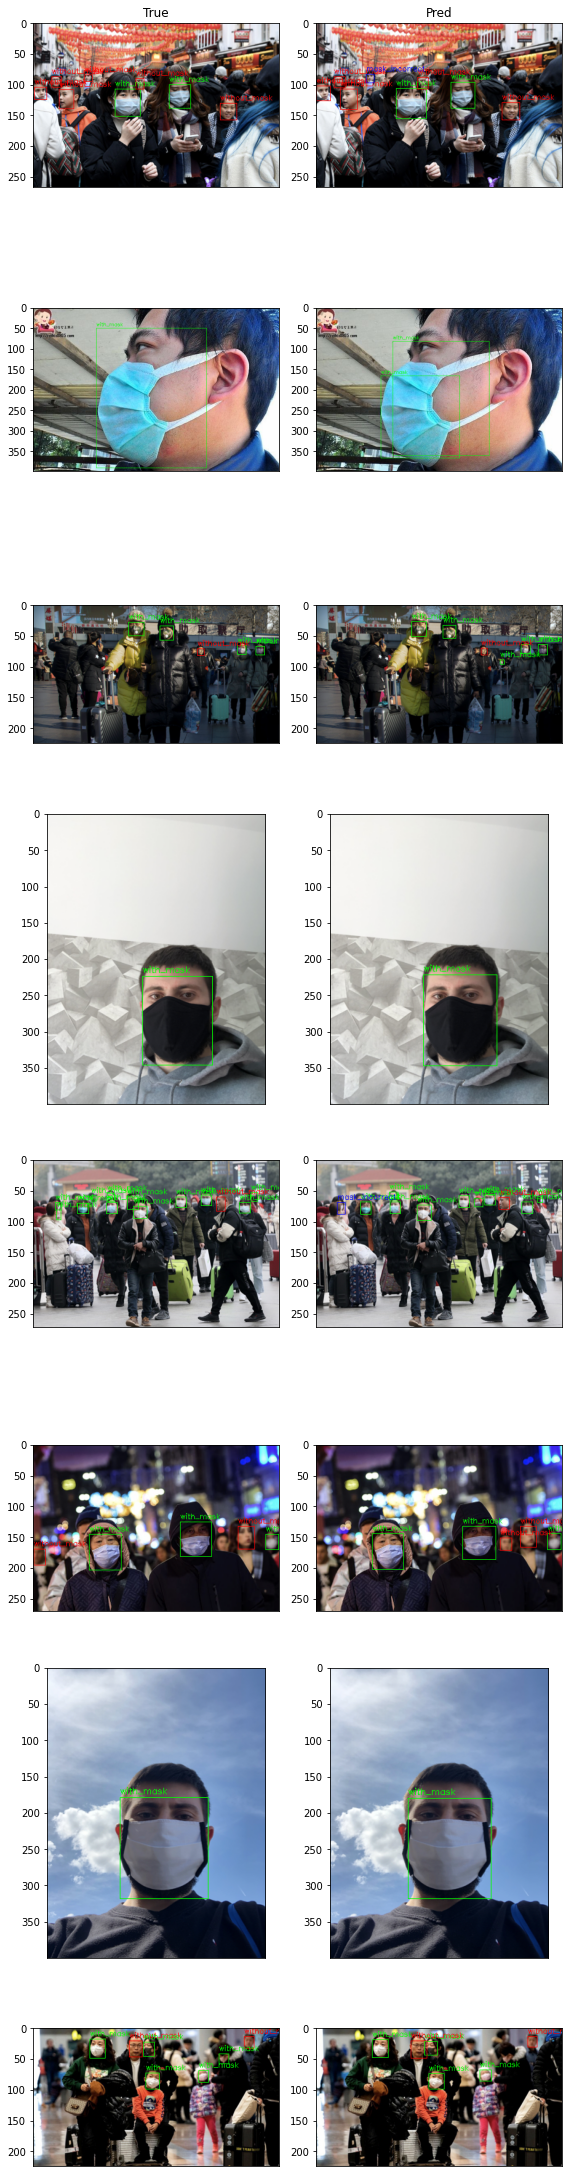

In [22]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows = 8, ncols = 2, figsize = (ncols * 4, nrows * 4))

batch_i = 0
row = 0
for im, annot in test_data_loader:
  for sample_i in range(len(im)):

    img = plot_image_from_output_cv(im[sample_i], annot[sample_i])
    axes[row, 0].imshow(img)
    img = plot_image_from_output_cv(im[sample_i], preds_adj_all[batch_i][sample_i])
    axes[row, 1].imshow(img)
    row += 1
  batch_i += 1
  if batch_i == 4:
    break

for idx, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_xticks([])

colnames = ['True', 'Pred']
for idx, ax in enumerate(axes[0]):
  ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

# 4.7. mAP 계산

In [23]:
!pwd

/content


In [24]:
# mAP 산출하는 모듈 import
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 9), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.
/content/Tutorial-Book-Utils


In [25]:
# batch 별로 mAP를 산출하는데 필요한 정보를 sample_metrics에 저장
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

In [31]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))] # batch를 모두 합친다
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels)) 
mAP = torch.mean(AP)
print(f'mAP: {mAP}')
print(f'AP: {AP}')

mAP: 0.6466687605176228
AP: tensor([0.7301, 0.9027, 0.3072], dtype=torch.float64)


* 0번 클래스(마스크 미착용) AP : 0.7301
* 1번 클래스(마스크 착용) AP : 0.9027
* 2번 클래스(마스크 오착용) AP : 0.3072